In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import iqr
from datasets import load_dataset
import seaborn as sns
sns.set_style("white")

/home/doricirkveni/miniconda3/envs/tpenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from data import *
train_df, val_df, test_df = make_base_dataset()

Found cached dataset humicroedit (/home/doricirkveni/.cache/huggingface/datasets/humicroedit/subtask-1/0.0.0/209c209bc70671d8d939aefd82e51f8ff294e47504ec64ef653a93a1f13e9ed3)
100%|██████████| 4/4 [00:00<00:00, 69.96it/s]


In [3]:
df = train_df
combined_df = pd.concat([train_df, val_df, test_df])

/tmp/ipykernel_264/797185932.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(combined_df['meanGrade'], palette="flare", bins=16, cumulative=False)


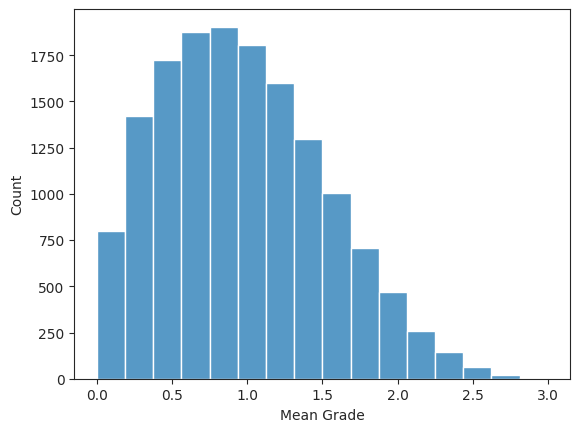

7725

In [4]:
# 1. Histogram of mean grades
sns.set_style("ticks")
sns.histplot(combined_df['meanGrade'], palette="flare", bins=16, cumulative=False)
plt.xlabel('Mean Grade')
plt.ylabel('Count')
plt.show()

len(combined_df[combined_df['meanGrade'] <= 0.9])

In [ ]:
# Flatten the grades data
flat_data = df.explode('grades')

# Convert 'grades' to numeric
flat_data['grades'] = pd.to_numeric(flat_data['grades'])

# Boxplot of grades
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

flat_data.boxplot(column='meanGrade', ax=ax[0])
ax[0].set_title('Boxplot of Mean Grades')
ax[0].set_ylabel('Grades')

flat_data.boxplot(column='most_common_grade', ax=ax[1])
ax[1].set_title('Boxplot of most common grades')
ax[1].set_ylabel('Grades')
plt.show()

In [ ]:
# 3. Scatter plot of mean grades vs standard deviation of grades
plt.scatter(df['meanGrade'], df['stddev'])
plt.title('Scatter Plot of Mean Grades vs Standard Deviation')
plt.xlabel('Mean Grade')
plt.ylabel('Standard Deviation')
plt.grid(True)
plt.show()

In [ ]:
# Print 5 funniest lines
print("\n5 Funniest Lines:")
funniest = combined_df.sort_values(by='meanGrade', ascending=False).head(50)
for i, row in funniest.iterrows():
    print(f"{row['arrow_sentence']}, Mean Grade: {row['meanGrade']}")

# Print 5 least funny lines
print("\n5 Least Funny Lines:")
least_funny = combined_df.sort_values(by='meanGrade').head(50)
for i, row in least_funny.iterrows():
    print(f"{row['arrow_sentence']}, Mean Grade: {row['meanGrade']}")

# Print 5 lines with biggest variance
print("\n10 Lines With Biggest Variance:")
biggest_variance = combined_df.sort_values(by='stddev', ascending=False).head(50)
for i, row in biggest_variance.iterrows():
    print(f"{row['arrow_sentence']}, Mean: {row['meanGrade']}, Std Dev: {row['stddev']}")


In [ ]:
# 1. Bucketize stddev into 4 bins
df['stddev_bucket'], bins = pd.cut(df['stddev'], bins=4, retbins=True, labels=["low", "medium-low", "medium-high", "high"])

# Get unique labels
labels = df['stddev_bucket'].unique().sort_values()

print(bins)
print(labels)

# 2. Create a histogram of mean grades for each stddev bucket.
fig, axs = plt.subplots(2, 2, figsize=(12, 14))
i = 0
for i in range(len(labels)):
    label = labels[i]
    bin_from, bin_to = bins[i], bins[i + 1]
    axs[i // 2, i % 2].hist(df[df['stddev_bucket'] == label]['meanGrade'], bins=10, edgecolor='black')
    axs[i // 2, i % 2].set_title(f'Histogram of Mean Grades for {label.capitalize()} Stddev Bucket\n({bin_from:.2f} - {bin_to:.2f})')
    axs[i // 2, i % 2].set_xlabel('Mean Grade')
    axs[i // 2, i % 2].set_ylabel('Count')
    i += 1
plt.show()

# 3. Plot a histogram of all individual grades for rows that fall into a particular stddev bucket.
fig, axs = plt.subplots(2, 2, figsize=(12, 14))
i = 0
for i in range(len(labels)):
    label = labels[i]
    bin_from, bin_to = bins[i], bins[i + 1]
    grades_in_bucket = df[df['stddev_bucket'] == label]['grades']
    grades_in_bucket = [item for sublist in grades_in_bucket for item in sublist]  # flatten list of lists

    axs[i // 2, i % 2].hist(grades_in_bucket, bins=range(5), edgecolor='black', align='left')
    axs[i // 2, i % 2].set_title(f'Histogram of Individual Grades for {label.capitalize()} Stddev Bucket\n({bin_from:.2f} - {bin_to:.2f})')
    axs[i // 2, i % 2].set_xlabel('Grade')
    axs[i // 2, i % 2].set_ylabel('Count')
    axs[i // 2, i % 2].set_xticks(range(4))
    i += 1
plt.show()


In [ ]:
import json

try:
    
    with open('train_topics_cache.json', 'r') as f:
        topics = json.load(f)
        df['topics'] = df['id'].apply(lambda id: topics[id])
except:

    from transformers import pipeline
    import torch
    torch.cuda.empty_cache()

    # Assume that these are your news headlines
    headlines = []
    for i, row in df.iterrows():
        o, e = row['original'], row['edit']
        #h = o.replace('<', '(').replace('/>', f', {e})')
        h = o
        headlines.append(h)

    # Define the topics you want to classify the headlines into
    topics = ["Business", "Science", "Health", "Politics", "Democrats", "Republicans", "Trump", "Biden", "Economy", "Sports", "Entertainment", "Technology", "Education", "World", "US", "Crime"]

    # Create a zero-shot classification pipeline
    classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)

    # Iterate over the headlines and classify each into a topic
    df['topics'] = ''

    batch_size = 1000
    i = 0
    while i < len(headlines):
        # Make the prediction
        result = classifier(headlines[i:i+batch_size], topics)

        # Get the best matching topic
        for j, r in enumerate(result):
            scores = sorted(r['scores'])
            best_topic        = r['labels'][r['scores'].index(scores[-1])]
            second_best_topic = r['labels'][r['scores'].index(scores[-2])]
            third_best_topic  = r['labels'][r['scores'].index(scores[-3])]

            #print(f'Headline: {i+j}/{len(headlines)} "{headlines[i+j]}" \nBest Matching Topics: {best_topic}, {second_best_topic}, {third_best_topic}')
            df.at[i+j, 'topics'] = [best_topic, second_best_topic, third_best_topic]

        i += batch_size
        print(f'Finished headlines {i}/{len(headlines)}')

    topics = {}
    for i, row in df.iterrows():
        topics[row['id']] = row['topics']

    with open('train_topics_cache.txt', 'w') as f:
        json.dump(topics, f)


try:
    with open('train_edit_topics_cache.json', 'r') as f:
        topics = json.load(f)
        df['edit_topics'] = df['id'].apply(lambda id: topics[id])
except:

    from transformers import pipeline
    import torch
    torch.cuda.empty_cache()

    # Assume that these are your news headlines
    headlines = []
    for i, row in df.iterrows():
        o, e = row['original'], row['edit']
        #h = o.replace('<', '(').replace('/>', f', {e})')
        #h = o
        h = e
        headlines.append(h)

    # Define the topics you want to classify the funny words
    topics = ["sexual", "bodypart", "family", "food", "trump", "politics", "children", "clothes", "fashion", "animals" , "drugs", "silly", "places", "profession", "disease", "relationships", "aging", "money" ]

    # Create a zero-shot classification pipeline
    classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)

    # Iterate over the headlines and classify each into a topic
    df['edit_topics'] = ''

    batch_size = 100
    i = 0
    while i < len(headlines):
        # Make the prediction
        result = classifier(headlines[i:i+batch_size], topics)

        # Get the best matching topic
        for j, r in enumerate(result):
            scores = sorted(r['scores'])
            best_topic        = r['labels'][r['scores'].index(scores[-1])]
            second_best_topic = r['labels'][r['scores'].index(scores[-2])]
            third_best_topic  = r['labels'][r['scores'].index(scores[-3])]

            print(f'Headline: {i+j}/{len(headlines)} "{headlines[i+j]}", Best Matching Topics: {best_topic}, {second_best_topic}, {third_best_topic}')
            df.at[i+j, 'edit_topics'] = [best_topic, second_best_topic, third_best_topic]

        i += batch_size
        print(f'Finished headlines {i}/{len(headlines)}')

    topics = {}
    for i, row in df.iterrows():
        topics[row['id']] = row['edit_topics']

    with open('train_edit_topics_cache.json', 'w') as f:
        json.dump(topics, f)

In [ ]:
# Explode the dataframe on 'topics' so each topic is in a separate row
#df_exploded = df.explode('topics')
df_exploded = df.copy()
df_exploded['topics'] = df['topics'].apply(lambda ts: ts[0])

# Box plot of grades per topic
plt.figure(figsize=(12, 8))
sns.boxplot(x="topics", y="meanGrade", data=df_exploded)
plt.title('Box Plot of Mean Grades per Topic')
plt.xticks(rotation=90)
plt.show()

# Scatter plot of mean grades vs stddev, colored by topic
plt.figure(figsize=(12, 8))
sns.scatterplot(x="meanGrade", y="stddev", hue="topics", data=df_exploded)
plt.title('Scatter Plot of Mean Grades vs Standard Deviation, Colored by Topic')
plt.show()

# Two additional visualizations:
# 1. Count plot of topics
plt.figure(figsize=(12, 8))
sns.countplot(x="topics", data=df_exploded, order = df_exploded['topics'].value_counts().index)
plt.title('Count of Headlines per Topic')
plt.xticks(rotation=90)
plt.show()

# 2. Box plot of stddev per topic
plt.figure(figsize=(12, 8))
sns.boxplot(x="topics", y="stddev", data=df_exploded)
plt.title('Box Plot of Stddev per Topic')
plt.xticks(rotation=90)
plt.show()


In [ ]:
print(len(df.index))

# Explode the dataframe on 'topics' so each topic is in a separate row
#df_exploded = df.explode('topics')
df_edit_topics = df.copy()
df_edit_topics['edit_topics'] = df['edit_topics'].apply(lambda ts: ts[0])

# Box plot of grades per topic
plt.figure(figsize=(12, 8))
sns.boxplot(x="edit_topics", y="meanGrade", data=df_edit_topics)
plt.title('Box Plot of Mean Grades per Edit Topic')
plt.xticks(rotation=90)
plt.show()

# Scatter plot of mean grades vs stddev, colored by topic
plt.figure(figsize=(12, 8))
sns.scatterplot(x="meanGrade", y="stddev", hue="edit_topics", data=df_edit_topics)
plt.title('Scatter Plot of Mean Grades vs Standard Deviation, Colored by Edit Topic')
plt.show()

# Two additional visualizations:
# 1. Count plot of edit_topics
plt.figure(figsize=(12, 8))
sns.countplot(x="edit_topics", data=df_edit_topics, order = df_edit_topics['edit_topics'].value_counts().index)
plt.title('Count of Headlines per Edit Topic')
plt.xticks(rotation=90)
plt.show()

# 2. Box plot of stddev per topic
plt.figure(figsize=(12, 8))
sns.boxplot(x="edit_topics", y="stddev", data=df_edit_topics)
plt.title('Box Plot of Stddev per Edit Topic')
plt.xticks(rotation=90)
plt.show()


In [ ]:
agreement_names = ['All Agree', 'One Disagreement', 'Two Disagreements', 'Three Disagreements']

def deconstruct_by_agreeableness(df):
    df_all_agree = df[df['disagreements'] == 0]
    df_one_disagree = df[df['disagreements'] == 1]
    df_two_disagree = df[df['disagreements'] == 2]
    df_three_disagree = df[df['disagreements'] == 3]
    assert len(df_all_agree.index) + len(df_one_disagree.index) + len(df_two_disagree.index) + len(df_three_disagree.index) == len(df.index)
    return df_all_agree, df_one_disagree, df_two_disagree, df_three_disagree

df_all_agree, df_one_disagree, df_two_disagree, df_three_disagree = deconstruct_by_agreeableness(df)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
dfs = deconstruct_by_agreeableness(df)
for i, df_agreement in enumerate(dfs):
    print(i)
    # remove all where topic is trump
    df_agreement['topics'] = df['topics'].apply(lambda ts: ts[0])
    df_agreement = df_agreement[df_agreement['topics'] != 'trump']

    axs[i // 2, i % 2].hist(df_agreement['most_common_grade'], bins=4, edgecolor='black')
    axs[i // 2, i % 2].set_title(f"Most common grade for: {agreement_names[i]}")
    axs[i // 2, i % 2].set_xlabel('Mean Grade')
    axs[i // 2, i % 2].set_ylabel('Count')

In [ ]:
# Explode the dataframe on 'topics' so each topic is in a separate row
#df_exploded = df.explode('topics')
df_exploded = df_one_disagree.copy()
df_exploded['topics'] = df['topics'].apply(lambda ts: ts[0])

# for each topic, get the mean most common grade and stddev for most common grade, and set as new cols
df_exploded['most_common_grade'] = df_exploded['most_common_grade'].astype(float)
df_exploded['mean_most_common_grade'] = df_exploded.groupby('topics')['most_common_grade'].transform('mean')
df_exploded['stddev_most_common_grade'] = df_exploded.groupby('topics')['most_common_grade'].transform('std')

# Box plot of grades per topic
plt.figure(figsize=(12, 8))
sns.boxplot(x="topics", y="meanGrade", data=df_exploded)
plt.title('Box Plot of Mean Grades per Topic')
plt.xticks(rotation=90)
plt.show()

# Scatter plot of mean grades vs stddev, colored by topic
plt.figure(figsize=(12, 8))
sns.scatterplot(x="meanGrade", y="stddev", hue="topics", data=df_exploded)
plt.title('Scatter Plot of Mean Grades vs Standard Deviation, Colored by Topic')
plt.show()

# Two additional visualizations:
# 1. Count plot of topics
plt.figure(figsize=(12, 8))
sns.countplot(x="topics", data=df_exploded, order = df_exploded['topics'].value_counts().index)
plt.title('Count of Headlines per Topic')
plt.xticks(rotation=90)
plt.show()

# 2. Box plot of stddev per topic
plt.figure(figsize=(12, 8))
sns.boxplot(x="topics", y="stddev", data=df_exploded)
plt.title('Box Plot of Stddev per Topic')
plt.xticks(rotation=90)
plt.show()

In [ ]:
from transformers import AutoTokenizer, AutoModel
from model_test import fit_regression, compute_metrics_regression
from data import TokenizedSentencesDataset

tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model, trainer = fit_regression('sentence-transformers/all-MiniLM-L6-v2', './fit_out', train_df, val_df, test_df)

In [ ]:
class TokenizedSentencesDataset(Dataset):
    def __init__(self, tokenizer, dataframe):
        self.df = dataframe
        
        original = self.df["original_sentence"].tolist()
        edited   = self.df["edited_sentence"].tolist()
        text = [f"{o} [SEP] {e}" for o, e in zip(original, edited)]
        print(len(text))
        output = tokenizer(text=text, truncation=True, padding=True, return_tensors='pt')
        
        self.input_ids      = output["input_ids"]
        self.attention_mask = output["attention_mask"]
        #self.labels         = torch.tensor(self.df['most_common_grade'].values, dtype=torch.float32)
        self.labels         = torch.tensor(self.df['normalized_score'].values, dtype=torch.float32)
    def __len__(self):
        return len(self.df.index)

    def __getitem__(self, idx):
        return {
            "input_ids":      self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels":         self.labels[idx],
        }

# put computed metrics into new dataframe
df_metrics = pd.DataFrame(columns=['agreement', 'grade', 'pearson', 'spearman', 'rmse'])
overall_mses = []
for i, df_agreement in enumerate(deconstruct_by_agreeableness(test_df)):
    for grade in range(0, 3+1):
        df_agrement_and_grade = df_agreement[df_agreement['most_common_grade'] == grade]
        if len(df_agrement_and_grade) == 0:
            continue
        out = trainer.predict(TokenizedSentencesDataset(tokenizer, df_agrement_and_grade))
        metrics = compute_metrics_regression((out.predictions, out.label_ids))
        print(f"Metrics for {agreement_names[i]}, grade {grade}: {metrics}")

        # store metric in dataframe
        df_metrics = df_metrics.append({
            'agreement': agreement_names[i],
            'grade': grade,
            #'pearson': metrics['pearson'],
            #'spearman': metrics['spearman'],
            'rmse': metrics['rmse'],
        }, ignore_index=True)
    
    out = trainer.predict(TokenizedSentencesDataset(tokenizer, df_agreement))
    metrics = compute_metrics_regression((out.predictions, out.label_ids))
    df_metrics = df_metrics.append({
            'agreement': agreement_names[i],
            'grade': -1,
            #'pearson': metrics['pearson'],
            #'spearman': metrics['spearman'],
            'rmse': metrics['rmse'],
        }, ignore_index=True)
    overall_mses.append(metrics['rmse'])

    print(f"Metrics for {agreement_names[i]}, combined grades: {metrics}")

# separate barplot of rmse for each agreement level
plt.figure(figsize=(12, 8))
ax = sns.barplot(x="agreement", y="rmse", hue="grade", data=df_metrics[df_metrics['grade'] != -1], palette="flare")
ax.hlines(
    y=overall_mses, 
    xmin=[i-0.5 for i in range(len(overall_mses))],
    xmax=[i+0.5 for i in range(len(overall_mses))], 
    ls='--', color='black'
)
plt.title('RMSE for Each Agreement Level')
#plt.xticks(rotation=90)
plt.show()


plt.figure(figsize=(12, 8))
ax = sns.barplot(x="agreement", y="rmse", data=df_metrics[df_metrics['grade'] == -1], palette="flare")
ax.axhline(0.55, ls='--', color='black')
plt.title('Overall RMSE')
#plt.xticks(rotation=90)
plt.show()

print(df_metrics[(df_metrics['grade'] == 3) & (df_metrics['agreement'] == 'All Agree')])

In [ ]:
print(df_metrics[(df_metrics['grade'] == 3) & (df_metrics['agreement'] == 'All Agree')])

In [ ]:
dfs = deconstruct_by_agreeableness(df)

# Compute grade counts for each dataframe
grade_counts = [df['most_common_grade'].value_counts(normalize=False) for df in dfs]

# Convert grade counts to a DataFrame
grade_counts_df = pd.DataFrame(grade_counts).T
grade_counts_df.columns = agreement_names

# Plot
grade_counts_df.plot(kind='bar', stacked=True, figsize=(10, 7), color=sns.color_palette("flare", n_colors=4)[::-1])
plt.title('Agreement Classes and Most Common Grades')
plt.xlabel('N')
plt.ylabel('Grade')
plt.show()


dfs = deconstruct_by_agreeableness(combined_df)

# Create bins for meanGrade
bins = np.linspace(0, 3, 17)  # 16 bins between 0 and 3

# Create a new dataframe list for storing modified dfs
dfs_mod = []

# Create a new column in each dataframe for the binned meanGrade
for df in dfs:
    df_copy = df.copy()  # Copy the DataFrame to avoid SettingWithCopyWarning
    df_copy['meanGrade_bin'] = pd.cut(df_copy['meanGrade'], bins, labels=False, include_lowest=True) + 1
    dfs_mod.append(df_copy)

# Compute grade counts for each dataframe
grade_counts = [df['mean_grade_bin'].value_counts(normalize=False).sort_index() for df in dfs_mod]

# Convert grade counts to a DataFrame
grade_counts_df = pd.DataFrame(grade_counts).T
grade_counts_df.columns = ["5/5 Agree (Consensus)", "4/5 Agree", "3/5 Agree", "2/5 Agree"]

# Plot
#diverging_colors = sns.color_palette("RdPu", 10)
#
grade_counts_df.plot(kind='bar', stacked=True, figsize=(10, 7), width=1.0, edgecolor='black', color=sns.color_palette("Blues", n_colors=4)[::-1])
plt.xlabel('Mean Grade Range')
plt.ylabel('Count')
plt.xticks(ticks=range(16), labels=["{0:.1f}-{1:.1f}".format(bins[i], bins[i+1]) for i in range(16)], rotation=45)
plt.show()



In [ ]:
# Compute disagreement counts for each dataframe
disagreement_counts = [df['most_common_grade'].value_counts(normalize=True) for df in dfs]

# Convert disagreement counts to a DataFrame
disagreement_counts_df = pd.DataFrame(disagreement_counts).T
disagreement_counts_df.columns = ['5/5 Agree\n(Concensus)', '4/5 Agree', '3/5 Agree', '2/5 Agree']

# Transpose the DataFrame to get disagreement classes as bars
disagreement_counts_df = disagreement_counts_df.transpose()

# Plot
cmap = sns.color_palette("flare", n_colors=4)[::-1]

disagreement_counts_df.plot(kind='barh', stacked=True, figsize=(10, 7), color=cmap).invert_yaxis()
plt.title('Grade Distribution per Agreement Class')
plt.xlabel('Percentage')
plt.ylabel('Agreement Class')
plt.legend(title='Most Common Grade')
plt.show()


In [ ]:
 
#{ 'dataset': 'KEPT'   model: 'randomly sampled',  disagreement 0 (threshold 0.8): {'mae': 0.7708974409103394, 'mse': 0.7549566245722571, 'rmse': 0.8688823997367291}
#{ 'dataset': 'KEPT'   model: 'refined data',      disagreement 0 (threshold 0.8): {'mae': 1.1947281217575074, 'mse': 1.6457225016459205, 'rmse': 1.2828571633841082}
#{ 'dataset': 'ENTIRE' model: 'randomly sampled',  disagreement 0 (threshold 0.8): {'mae': 0.8496183668865877, 'mse': 0.8022210720854362, 'rmse': 0.8956679474478454}
#{ 'dataset': 'ENTIRE' model: 'refined data',      disagreement 0 (threshold 0.8): {'mae': 1.3842397381277645, 'mse': 2.0110816431274294, 'rmse': 1.4181261026888368}
#{ 'dataset': 'KEPT'   model: 'randomly sampled',  disagreement 1 (threshold 0.8): {'mae': 0.5950841200351715, 'mse': 0.4587049847721751, 'rmse': 0.677277627544403}
#{ 'dataset': 'KEPT'   model: 'refined data',      disagreement 1 (threshold 0.8): {'mae': 0.9578437507152557, 'mse': 1.104062448594309, 'rmse': 1.0507437597218023}
#{ 'dataset': 'ENTIRE' model: 'randomly sampled',  disagreement 1 (threshold 0.8): {'mae': 0.6172205818002112, 'mse': 0.45669913798666817, 'rmse': 0.6757951893781637}
#{ 'dataset': 'ENTIRE' model: 'refined data',      disagreement 1 (threshold 0.8): {'mae': 1.0630526703898795, 'mse': 1.2588998793999693, 'rmse': 1.122007076359133}
#{ 'dataset': 'KEPT'   model: 'randomly sampled',  disagreement 2 (threshold 0.8): {'mae': 0.5152952637684558, 'mse': 0.4047397753387257, 'rmse': 0.636191618412822}
#{ 'dataset': 'KEPT'   model: 'refined data',      disagreement 2 (threshold 0.8): {'mae': 0.5900502785774892, 'mse': 0.48183372218797293, 'rmse': 0.6941424365272396}
#{ 'dataset': 'ENTIRE' model: 'randomly sampled',  disagreement 2 (threshold 0.8): {'mae': 0.4306439177331248, 'mse': 0.2720599061841849, 'rmse': 0.5215936216866393}
#{ 'dataset': 'ENTIRE' model: 'refined data',      disagreement 2 (threshold 0.8): {'mae': 0.7028733493840684, 'mse': 0.6203621750667347, 'rmse': 0.7876307352222454}
#{ 'dataset': 'KEPT'   model: 'randomly sampled',  disagreement 3 (threshold 0.8): {'mae': 0.4303677698520765, 'mse': 0.2950672052133709, 'rmse': 0.5432008884504617}
#{ 'dataset': 'KEPT'   model: 'refined data',      disagreement 3 (threshold 0.8): {'mae': 0.3773945832633537, 'mse': 0.20071710776042836, 'rmse': 0.4480146289580602}
#{ 'dataset': 'ENTIRE' model: 'randomly sampled',  disagreement 3 (threshold 0.8): {'mae': 0.38164039871617816, 'mse': 0.2424444785399681, 'rmse': 0.4923865133611684}
#{ 'dataset': 'ENTIRE' model: 'refined data',      disagreement 3 (threshold 0.8): {'mae': 0.4021579368232077, 'mse': 0.22083215462270328, 'rmse': 0.46992781852397636}

#KEPT   dataset, entire set model, disagreement 0 (threshold 0.8): {'mae': 0.7413814520835876, 'mse': 0.7024504329416097, 'rmse': 0.8381231609624028}
#KEPT   dataset, kept-only        model, disagreement 0 (threshold 0.8): {'mae': 1.2192668390274048, 'mse': 1.7215445900930462, 'rmse': 1.3120764421683084}
#ENTIRE dataset, entire set model, disagreement 0 (threshold 0.8): {'mae': 0.7974914252758026, 'mse': 0.7029073651703219, 'rmse': 0.8383957091793361}
#ENTIRE dataset, kept-only        model, disagreement 0 (threshold 0.8): {'mae': 1.3947345298879288, 'mse': 2.046829373529656, 'rmse': 1.4306744470806962}
#KEPT   dataset, entire set model, disagreement 1 (threshold 0.8): {'mae': 0.586527540922165, 'mse': 0.446907995741235, 'rmse': 0.6685117768156632}
#KEPT   dataset, kept-only        model, disagreement 1 (threshold 0.8): {'mae': 0.9625296218395233, 'mse': 1.1041413820081165, 'rmse': 1.050781319784529}
#ENTIRE dataset, entire set model, disagreement 1 (threshold 0.8): {'mae': 0.5768714070436545, 'mse': 0.41018517171680546, 'rmse': 0.6404570022388744}
#ENTIRE dataset, kept-only        model, disagreement 1 (threshold 0.8): {'mae': 1.0701831144397147, 'mse': 1.2728756160988088, 'rmse': 1.128217893892314}
#KEPT   dataset, entire set model, disagreement 2 (threshold 0.8): {'mae': 0.5172069427621273, 'mse': 0.40481194649308855, 'rmse': 0.6362483371240263}
#KEPT   dataset, kept-only        model, disagreement 2 (threshold 0.8): {'mae': 0.58880672397201, 'mse': 0.4808566933091022, 'rmse': 0.6934383125477724}
#ENTIRE dataset, entire set model, disagreement 2 (threshold 0.8): {'mae': 0.4077129732960108, 'mse': 0.2566611542477327, 'rmse': 0.5066173647317399}
#ENTIRE dataset, kept-only        model, disagreement 2 (threshold 0.8): {'mae': 0.706048510962613, 'mse': 0.6227710308918454, 'rmse': 0.7891584320602837}
#KEPT   dataset, entire set model, disagreement 3 (threshold 0.8): {'mae': 0.4178176676029484, 'mse': 0.27900516632344835, 'rmse': 0.5282093962847011}
#KEPT   dataset, kept-only        model, disagreement 3 (threshold 0.8): {'mae': 0.3797878618926218, 'mse': 0.20275371804176529, 'rmse': 0.4502818206876281}
#ENTIRE dataset, entire set model, disagreement 3 (threshold 0.8): {'mae': 0.3868751161836188, 'mse': 0.24948764664997905, 'rmse': 0.4994873838746871}
#ENTIRE dataset, kept-only        model, disagreement 3 (threshold 0.8): {'mae': 0.40747104749551266, 'mse': 0.22633906634991705, 'rmse': 0.47575105501713505}
#KEPT   dataset, entire set model, meanGrade 0.0-0.5 (threshold 0.8): {'mae': 0.7045136007997724, 'mse': 0.5272123278862542, 'rmse': 0.7260938836584799}

{ 'dataset': 'KEPT',   'model': 'kept-only',        'mean_grade_bucket': '0.0 - 0.5', 'rmse': 1.2640821777011984 },
{ 'dataset': 'ENTIRE', 'model': 'kept-only',        'mean_grade_bucket': '0.0 - 0.5', 'rmse': 1.2658762338133176 },
{ 'dataset': 'KEPT',   'model': 'kept-only',        'mean_grade_bucket': '0.5 - 1.0', 'rmse': 0.7409811463413085 },
{ 'dataset': 'ENTIRE', 'model': 'kept-only',        'mean_grade_bucket': '0.5 - 1.0', 'rmse': 0.7535737631897971 },
{ 'dataset': 'KEPT',   'model': 'kept-only',        'mean_grade_bucket': '1.0 - 1.5', 'rmse': 0.3892582724031099 },
{ 'dataset': 'ENTIRE', 'model': 'kept-only',        'mean_grade_bucket': '1.0 - 1.5', 'rmse': 0.3995633921945709 },
{ 'dataset': 'KEPT',   'model': 'kept-only',        'mean_grade_bucket': '1.5 - 2.0', 'rmse': 0.27838517310414024 },
{ 'dataset': 'ENTIRE', 'model': 'kept-only',        'mean_grade_bucket': '1.5 - 2.0', 'rmse': 0.27338923178002955 },
{ 'dataset': 'KEPT',   'model': 'kept-only',        'mean_grade_bucket': '2.0 - 2.5', 'rmse': 0.609835113508833 },
{ 'dataset': 'ENTIRE', 'model': 'kept-only',        'mean_grade_bucket': '2.0 - 2.5', 'rmse': 0.594459892897418 },
{ 'dataset': 'KEPT',   'model': 'kept-only',        'mean_grade_bucket': '2.5 - 3.0', 'rmse': 1.0530526028551583 },
{ 'dataset': 'ENTIRE', 'model': 'kept-only',        'mean_grade_bucket': '2.5 - 3.0', 'rmse': 1.091694462311364 },


dinky_df = pd.DataFrame([
    { 'dataset': 'KEPT',    'model': 'randomly sampled', 'mean_grade_bucket': '0.0 - 3.0', 'rmse': 0.60956878995761 },
    { 'dataset': 'KEPT',    'model': 'refined data',     'mean_grade_bucket': '0.0 - 3.0', 'rmse': 0.682103854550248 },
    { 'dataset': 'ENTIRE',  'model': 'randomly sampled', 'mean_grade_bucket': '0.0 - 3.0', 'rmse': 0.5676318313297427 },
    { 'dataset': 'ENTIRE',  'model': 'refined data',     'mean_grade_bucket': '0.0 - 3.0', 'rmse': 0.8119993111375877 },
    { 'dataset': 'KEPT',    'model': 'randomly sampled', 'mean_grade_bucket': '0.0 - 0.5', 'rmse': 0.7282226979173854 },
    { 'dataset': 'KEPT',    'model': 'refined data',     'mean_grade_bucket': '0.0 - 0.5', 'rmse': 1.2630974437920222 },
    { 'dataset': 'ENTIRE',  'model': 'randomly sampled', 'mean_grade_bucket': '0.0 - 0.5', 'rmse': 0.7163780496513894 },
    { 'dataset': 'ENTIRE',  'model': 'refined data',     'mean_grade_bucket': '0.0 - 0.5', 'rmse': 1.2608005140785197 },
    { 'dataset': 'KEPT',    'model': 'randomly sampled', 'mean_grade_bucket': '0.5 - 1.0', 'rmse': 0.25779537198923363 },
    { 'dataset': 'KEPT',    'model': 'refined data',     'mean_grade_bucket': '0.5 - 1.0', 'rmse': 0.7298437438630255 },
    { 'dataset': 'ENTIRE',  'model': 'randomly sampled', 'mean_grade_bucket': '0.5 - 1.0', 'rmse': 0.2681923719980645 },
    { 'dataset': 'ENTIRE',  'model': 'refined data',     'mean_grade_bucket': '0.5 - 1.0', 'rmse': 0.7448765000354526 },
    { 'dataset': 'KEPT',    'model': 'randomly sampled', 'mean_grade_bucket': '1.0 - 1.5', 'rmse': 0.2710464052438125 },
    { 'dataset': 'KEPT',    'model': 'refined data',     'mean_grade_bucket': '1.0 - 1.5', 'rmse': 0.38479189205515074 },
    { 'dataset': 'ENTIRE',  'model': 'randomly sampled', 'mean_grade_bucket': '1.0 - 1.5', 'rmse': 0.27989636911271265 },
    { 'dataset': 'ENTIRE',  'model': 'refined data',     'mean_grade_bucket': '1.0 - 1.5', 'rmse': 0.3898444133812833 },
    { 'dataset': 'KEPT',    'model': 'randomly sampled', 'mean_grade_bucket': '1.5 - 2.0', 'rmse': 0.7654630273267387 },
    { 'dataset': 'KEPT',    'model': 'refined data',     'mean_grade_bucket': '1.5 - 2.0', 'rmse': 0.28044292075600924 },
    { 'dataset': 'ENTIRE',  'model': 'randomly sampled', 'mean_grade_bucket': '1.5 - 2.0', 'rmse': 0.770540437243583 },
    { 'dataset': 'ENTIRE',  'model': 'refined data',     'mean_grade_bucket': '1.5 - 2.0', 'rmse': 0.28219939850449705 },
    { 'dataset': 'KEPT',    'model': 'randomly sampled', 'mean_grade_bucket': '2.0 - 2.5', 'rmse': 1.1279920300625925 },
    { 'dataset': 'KEPT',    'model': 'refined data',     'mean_grade_bucket': '2.0 - 2.5', 'rmse': 0.6287969027249929 },
    { 'dataset': 'ENTIRE',  'model': 'randomly sampled', 'mean_grade_bucket': '2.0 - 2.5', 'rmse': 1.119837179152282 },
    { 'dataset': 'ENTIRE',  'model': 'refined data',     'mean_grade_bucket': '2.0 - 2.5', 'rmse': 0.6114348602316309 },
    { 'dataset': 'KEPT',    'model': 'randomly sampled', 'mean_grade_bucket': '2.5 - 3.0', 'rmse': 1.5829224580131365 },
    { 'dataset': 'KEPT',    'model': 'refined data',     'mean_grade_bucket': '2.5 - 3.0', 'rmse': 1.052275605984535 },
    { 'dataset': 'ENTIRE',  'model': 'randomly sampled', 'mean_grade_bucket': '2.5 - 3.0', 'rmse': 1.6270095279643135 },
    { 'dataset': 'ENTIRE',  'model': 'refined data',     'mean_grade_bucket': '2.5 - 3.0', 'rmse': 1.0933530581020658 },
    { 'dataset': 'KEPT',    'model': 'entire set',       'mean_grade_bucket': '0.0 - 3.0', 'rmse': 0.6013238178882069 },
    { 'dataset': 'ENTIRE',  'model': 'entire set',       'mean_grade_bucket': '0.0 - 3.0', 'rmse': 0.5523551715028504 },
    { 'dataset': 'ENTIRE',  'model': 'entire set',       'mean_grade_bucket': '0.0 - 0.5', 'rmse': 0.6673708202475422 },
    { 'dataset': 'KEPT',    'model': 'entire set',       'mean_grade_bucket': '0.5 - 1.0', 'rmse': 0.2661807776188036 },
    { 'dataset': 'ENTIRE',  'model': 'entire set',       'mean_grade_bucket': '0.5 - 1.0', 'rmse': 0.24179993696017035 },
    { 'dataset': 'KEPT',    'model': 'entire set',       'mean_grade_bucket': '1.0 - 1.5', 'rmse': 0.26665174124692165 },
    { 'dataset': 'ENTIRE',  'model': 'entire set',       'mean_grade_bucket': '1.0 - 1.5', 'rmse': 0.3001270171622522 },
    { 'dataset': 'KEPT',    'model': 'entire set',       'mean_grade_bucket': '1.5 - 2.0', 'rmse': 0.745534987183211 },
    { 'dataset': 'ENTIRE',  'model': 'entire set',       'mean_grade_bucket': '1.5 - 2.0', 'rmse': 0.7778305909162193 },
    { 'dataset': 'KEPT',    'model': 'entire set',       'mean_grade_bucket': '2.0 - 2.5', 'rmse': 1.0956012691388783 },
    { 'dataset': 'ENTIRE',  'model': 'entire set',       'mean_grade_bucket': '2.0 - 2.5', 'rmse': 1.119018057863962 },
    { 'dataset': 'KEPT',    'model': 'entire set',       'mean_grade_bucket': '2.5 - 3.0', 'rmse': 1.6075678009840064 },
    { 'dataset': 'ENTIRE',  'model': 'entire set',       'mean_grade_bucket': '2.5 - 3.0', 'rmse': 1.6434596593670368 },
])

sns.barplot(x='mean_grade_bucket', y='rmse', hue='model', palette='flare', data=dinky_df[dinky_df['dataset'] == 'KEPT'])
plt.title("refined dataset")
plt.show()
sns.barplot(x='mean_grade_bucket', y='rmse', hue='model', palette='flare', data=dinky_df[dinky_df['dataset'] == 'ENTIRE'])
plt.title("entire dataset")
plt.show()

In [ ]:
loaded_df = pd.read_json("results_grade_buckets.json")

sns.barplot(x='grade_bucket', y='rmse', hue='model', palette='flare', data=loaded_df)
plt.title("entire dataset")

# calculate average rmse for each model
avg_rmse = loaded_df.groupby(['model']).mean().reset_index()
print(avg_rmse)


In [ ]:
import statsmodels.api as sm
from scipy import stats

def round_to(n, fraction):
    return round(n / fraction) * fraction


loaded_df = pd.read_pickle("test_df_normalization_scores.pkl")

#loaded_df['hehe1'] = np.random.normal(0.23448527, 10 * 0.020161796, len(loaded_df))
#loaded_df['hehe2'] = np.random.normal(0.49663526, 10 * 0.00527176, len(loaded_df))

regression_cols = [
    'baseline_regresion_score',
    'refined_regression_score',
    'mixed_regression_score_scoring',
    'mixed_regression_score_lerp',
    #'hehe1',
    #'hehe2',
]

for col in regression_cols:
    loaded_df[col + '_rmse'] = loaded_df.apply(lambda row: np.sqrt((row[col] - row["normalized_score"])**2) , axis=1)

# create column mean_grade_bucket, rounded to nearest 0.1
loaded_df['mean_grade_bucket'] = loaded_df['meanGrade'].apply(lambda x: round_to(x, 0.2))

# print number of rows in each mean grade bucket
print(loaded_df.groupby(['mean_grade_bucket']).count()['id'])
print(loaded_df.groupby(['mean_grade_bucket']).count()['id'].sum(), len(loaded_df))

print(loaded_df[['id', 'meanGrade', 'mean_grade_bucket']].head(10))
# transform so that columns baseline_regresion_score, refined_regression_score, mixed_regression_score_scoring, mixed_regression_score_lerp
# become values of a new column "regression_type" and their values become values of column rmse
def draw1():
    dff = loaded_df.melt(
        id_vars=['id', 'meanGrade', 'mean_grade_bucket'], 
        value_vars=[
            'baseline_regresion_score_rmse', 
            'refined_regression_score_rmse', 
            'mixed_regression_score_scoring_rmse', 
            'mixed_regression_score_lerp_rmse',
            #'hehe1_rmse',
            #'hehe2_rmse'
        ],
        var_name='regression_type', 
        value_name='rmse'
    )

    # remove mixed_regression_score_scoring_rmse, mixed_regression_score_lerp_rmse
    dff = dff[dff['regression_type'] != 'mixed_regression_score_scoring_rmse']
    dff = dff[dff['regression_type'] != 'mixed_regression_score_lerp_rmse']

    # compute pearson correlation coefficient
    print("PEARSON", dff.groupby(['regression_type']).corr()['rmse'])

    sns.lineplot(x='mean_grade_bucket', y='rmse', hue='regression_type', palette='flare', data=dff, style='regression_type', errorbar='sd', markers=True, dashes=False)
    plt.title("entire dataset")
    plt.show()

def draw2():
    dff = loaded_df.melt(
        id_vars=['id', 'meanGrade', 'mean_grade_bucket'], 
        value_vars=regression_cols,
        var_name='regression_type', 
        value_name='reg'
    )
    dff['reg'] *= 3

    ### t-test hehe1 vs baseline_regresion_score
    ##print(stats.ttest_ind(dff[dff['regression_type'] == 'hehe1']['reg'].to_numpy(), dff[dff['regression_type'] == 'baseline_regresion_score']['reg'].to_numpy()))
    ### t-test hehe2 vs refined_regression_score
    ##print(stats.ttest_ind(dff[dff['regression_type'] == 'hehe2']['reg'].to_numpy(), dff[dff['regression_type'] == 'refined_regression_score']['reg'].to_numpy()))
    
    # remove mixed_regression_score_scoring_rmse, mixed_regression_score_lerp_rmse
    dff = dff[dff['regression_type'] != 'mixed_regression_score_scoring']
    dff = dff[dff['regression_type'] != 'mixed_regression_score_lerp']

    # print correlation of reg and mean_grade_bucket
    print("CORR", dff.groupby(['regression_type']).corr()['reg'])

    sns.lineplot(x='mean_grade_bucket', y='reg', hue='regression_type', palette='flare', data=dff, style='regression_type', errorbar='sd', markers=True, dashes=False)
    plt.title("regression result, entire dataset")
    plt.show()

draw1()
draw2()

In [ ]:
def round_to(n, fraction):
    return round(n / fraction) * fraction


loaded_df = pd.read_pickle("val_df_normalization_scores.pkl")

loaded_df['mean_grade_bucket'] = loaded_df['meanGrade'].apply(lambda x: round_to(x, 0.2))

# calculate mean of baseline_regression_score when grouped by mean_grade_bucket
# store it as a scalar value
mean_baseline_regression_score = loaded_df.groupby(['mean_grade_bucket']).mean().reset_index()['baseline_regresion_score'].mean()
mean_refined_regression_score  = loaded_df.groupby(['mean_grade_bucket']).mean().reset_index()['refined_regression_score'].mean()

# same but stddev
std_baseline_regression_score = loaded_df.groupby(['mean_grade_bucket']).mean().reset_index()['baseline_regresion_score'].std()
std_refined_regression_score  = loaded_df.groupby(['mean_grade_bucket']).mean().reset_index()['refined_regression_score'].std()

print(mean_baseline_regression_score, std_baseline_regression_score)
print(mean_refined_regression_score, std_refined_regression_score)

regression_cols = [
    'baseline_regresion_score',
    'refined_regression_score',
    'mixed_regression_score_scoring',
    'mixed_regression_score_lerp',
]

for col in regression_cols:
    loaded_df[col + '_rmse'] = loaded_df.apply(lambda row: np.abs((row[col] - row["normalized_score"])) , axis=1)

# create column mean_grade_bucket, rounded to nearest 0.1


print(loaded_df[['id', 'meanGrade', 'mean_grade_bucket']].head(10))
# transform so that columns baseline_regresion_score, refined_regression_score, mixed_regression_score_scoring, mixed_regression_score_lerp
# become values of a new column "regression_type" and their values become values of column rmse
def draw1():
    dff = loaded_df.melt(
        id_vars=['id', 'meanGrade', 'mean_grade_bucket'], 
        value_vars=[
            'baseline_regresion_score_rmse', 
            'refined_regression_score_rmse', 
            'mixed_regression_score_scoring_rmse', 
            'mixed_regression_score_lerp_rmse',
        ],
        var_name='regression_type', 
        value_name='rmse'
    )

    # remove mixed_regression_score_scoring_rmse, mixed_regression_score_lerp_rmse
    dff = dff[dff['regression_type'] != 'mixed_regression_score_scoring_rmse']
    dff = dff[dff['regression_type'] != 'mixed_regression_score_lerp_rmse']

    
    
    sns.lineplot(x='mean_grade_bucket', y='rmse', hue='regression_type', palette='flare', data=dff, style='regression_type', errorbar='sd', markers=True, dashes=False)
    plt.title("entire dataset")
    plt.show()

def draw2():
    dff = loaded_df.melt(
        id_vars=['id', 'meanGrade', 'mean_grade_bucket'], 
        value_vars=regression_cols,
        var_name='regression_type', 
        value_name='reg'
    )
    dff['reg'] *= 3

    # remove mixed_regression_score_scoring_rmse, mixed_regression_score_lerp_rmse
    dff = dff[dff['regression_type'] != 'mixed_regression_score_scoring']
    dff = dff[dff['regression_type'] != 'mixed_regression_score_lerp']

    sns.lineplot(x='mean_grade_bucket', y='reg', hue='regression_type', palette='flare', data=dff, style='regression_type', errorbar='sd', markers=True, dashes=False)
    plt.title("regression result, entire dataset")
    plt.show()

draw1()
draw2()

In [ ]:
from data import *
def test():
    train_df, val_df, test_df = make_base_dataset()
    train_df_please = train_df[(train_df['mean_grade_bucket'] != 1.0)]
    val_df_please   = val_df[(val_df['mean_grade_bucket'] != 1.0)]
    test_df_please  = test_df[(test_df['mean_grade_bucket'] != 1.0)]
    print(len(train_df), len(val_df), len(test_df))
    print(len(train_df_please), len(val_df_please), len(test_df_please))
test()

In [ ]:
import statsmodels.api as sm
from scipy import stats
from dieboldmariano import dm_test

def round_to(n, fraction):
    return round(n / fraction) * fraction


def load_and_plot_df(ax1, ax2, path, label, mae_results, mse_results, reg_results):
    loaded_df = pd.read_pickle(path)

    loaded_df['mean_grade_bucket'] = loaded_df['meanGrade'].apply(lambda x: round_to(x, 0.5))

    loaded_df['baseline_regression_score_mse'] = loaded_df.apply(lambda row: ((row['baseline_regression_score']*3 - row["meanGrade"])**2) , axis=1)
    loaded_df['cleaned_regression_score_mse']  = loaded_df.apply(lambda row: ((row['cleaned_regression_score'] *3 - row["meanGrade"])**2) , axis=1)

    # sum all rmses for each mean grade bucket, and divide by number of buckets
    average_rmse_baseline = np.sqrt(loaded_df.groupby(['mean_grade_bucket']).mean().reset_index()['baseline_regression_score_mse'].mean())
    average_rmse_cleaned  = np.sqrt(loaded_df.groupby(['mean_grade_bucket']).mean().reset_index()['cleaned_regression_score_mse'].mean())
    
    print(f"[{label}] total RMSE, baseline:", average_rmse_baseline)
    print(f"[{label}] total RMSE, cleaned: ", average_rmse_cleaned)
    
    def draw1():
        dff = loaded_df.melt(
            id_vars=['id', 'meanGrade', 'mean_grade_bucket'], 
            value_vars=[
                'baseline_regression_score_mse', 
                'cleaned_regression_score_mse', 
            ],
            var_name='regression_type', 
            value_name='mse'
        )

        dff['mae'] = dff.apply(lambda row: np.sqrt(row['mse']), axis=1)

        # make dataframe that contains the mse
        dff_mse = dff.groupby(['mean_grade_bucket', 'regression_type']).mean().reset_index()
        # apply sqrt
        dff_mse['rmse'] = dff_mse.apply(lambda row: np.sqrt(row['mse']), axis=1)

        # compute pearson correlation coefficient
        # print("PEARSON", dff.groupby(['regression_type']).corr()['rmse'])

        tests = [
            (dff[dff['meanGrade'] == dff['meanGrade'].quantile(0.05)], "bottom 5%"),
            (dff[dff['meanGrade'] == dff['meanGrade'].quantile(0.1)], "bottom 10%"),
            (dff[dff['meanGrade'] <= 0.4], "below Q1"),
            (dff[(dff['meanGrade'] >= 0.4) & (dff['meanGrade'] <= 1.4)], "between Q1 and Q3"),
            (dff[dff['meanGrade'] >= 1.4], "above Q3"),
            (dff, "entire dataset")
        ]
        for dfx, segment_name in tests:
            dfx1 = dfx[dfx['regression_type'] == 'baseline_regression_score_mse']
            dfx2 = dfx[dfx['regression_type'] == 'cleaned_regression_score_mse']

            pval = stats.ttest_ind(dfx1['mae'].to_numpy(), dfx2['mae'].to_numpy()).pvalue
            print(f"[{label}] t test for mae, {segment_name}", pval)

            mae_results.append({
                "model": label,
                "segment": segment_name,
                "pval": pval,
                "significant": pval < 0.05,
                "mae_baseline": dfx1['mae'].mean(),
                "mae_cleaned":  dfx2['mae'].mean(),
            })

            pval = stats.ttest_ind(dfx1['mse'].to_numpy(), dfx2['mse'].to_numpy()).pvalue
            print(f"[{label}] t test for mse, {segment_name}", pval)            
            mse_results.append({
                "model": label,
                "segment": segment_name,
                "pval": pval,
                "significant": pval < 0.05,
                "mse_baseline": dfx1['mse'].mean(),
                "mse_cleaned":  dfx2['mse'].mean(),
            })

        sns.lineplot(x='mean_grade_bucket', y='mae', hue='regression_type', palette='flare', data=dff, style='regression_type', errorbar=None, markers=True, dashes=False, ax=ax1)
        
        # make dataframe that contains the mse
        dff_mse = dff.groupby(['mean_grade_bucket', 'regression_type']).mean().reset_index()
        # apply sqrt
        dff_mse['rmse'] = dff_mse.apply(lambda row: np.sqrt(row['mse']), axis=1)

        display_copy = dff_mse.copy().rename(columns={
            'baseline_regression_score_mse': 'Baseline',
            'cleaned_regression_score_mse': 'NoMiddle50',
            'mean_grade_bucket': 'Mean Grade',
            'mse': 'MSE',
            'rmse': 'RMSE',
            'regression_type': 'Model',
        })
        display_copy['Model'].replace('baseline_regression_score_mse', 'Baseline', inplace=True)
        display_copy['Model'].replace('cleaned_regression_score_mse', 'NoMiddle50', inplace=True)

        sns.lineplot(x='Mean Grade', y='RMSE', hue='Model', palette='flare', data=display_copy, style='Model', errorbar=None, markers=True, dashes=False)
        plt.show()
        

    def draw2():
        dff = loaded_df.melt(
            id_vars=['id', 'meanGrade', 'mean_grade_bucket'], 
            value_vars=[
                'baseline_regression_score', 
                'cleaned_regression_score', 
            ],
            var_name='regression_type', 
            value_name='reg'
        )
        dff['reg'] *= 3


        # print correlation of reg and mean_grade_bucket
        # print("CORR", dff.groupby(['regression_type']).corr()['reg'])

        tests = [
            (dff[dff['meanGrade'] <= 0.4], "below Q1"),
            (dff[(dff['meanGrade'] >= 0.4) & (dff['meanGrade'] <= 1.4)], "between Q1 and Q3"),
            (dff[dff['meanGrade'] >= 1.4], "above Q3"),
        ]
        for dfx, segment_name in tests:
            dfx1 = dfx[dfx['regression_type'] == 'baseline_regression_score']
            dfx2 = dfx[dfx['regression_type'] == 'cleaned_regression_score']
            pval = stats.ttest_ind(dfx1['reg'].to_numpy(), dfx2['reg'].to_numpy()).pvalue
            print(f"[{label}] t test for regression, {segment_name}", pval)
            reg_results.append({
                "model": label,
                "segment": segment_name,
                "pval": pval,
                "significant": pval < 0.05,
                "reg_baseline": dfx1['reg'].mean(),
                "reg_cleaned":  dfx2['reg'].mean(),
            })

        sns.lineplot(x='mean_grade_bucket', y='reg', hue='regression_type', palette='flare', data=dff, style='regression_type', errorbar=None, markers=True, dashes=False, ax=ax2)
        
    draw1()
    draw2()

fig1, axes1 = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig2, axes2 = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

mae_results = []
mse_results = []
reg_results = []
load_and_plot_df(axes1[0], axes2[0], "test_df_with_scores.pkl",      "< Q1 removed", mae_results, mse_results, reg_results)
load_and_plot_df(axes1[1], axes2[1], "test_df_with_scores_2pls.pkl", "Q1 - Q3 removed", mae_results, mse_results, reg_results)
load_and_plot_df(axes1[2], axes2[2], "test_df_with_scores3.pkl",     "> Q3 removed", mae_results, mse_results, reg_results)

for ax in axes1:
    ax.set_xlim([0-0.1, 3+0.1])
    ax.set_ylim([0, 2+0.1])
for ax in axes2:
    ax.set_xlim([0, 3])
    ax.set_ylim([0, 3])

fig1.show()
fig2.show()

pd.DataFrame(mse_results).to_excel("mse_results.xlsx")
pd.DataFrame(mae_results).to_excel("mae_results.xlsx")

In [ ]:
# number of rows where most_common_grade == 0 and atleast one grade is 3

from collections import defaultdict
counts = defaultdict(int)
for _, row in combined_df.iterrows():
    has_1 = np.sum(row['grades'] >= 1) > 1
    has_2 = np.sum(row['grades'] >= 2) > 1
    has_3 = np.sum(row['grades'] >= 3) > 1

    if has_1 and row['most_common_grade'] != 1:
        counts[(row['most_common_grade'], 1)] += 1
    if has_2 and row['most_common_grade'] != 2:
        counts[(row['most_common_grade'], 2)] += 1
    if has_3 and row['most_common_grade'] != 3:
        counts[(row['most_common_grade'], 3)] += 1

for most_common, grade in sorted(counts):
    print(most_common, grade, counts[(most_common, grade)])

print(len(combined_df[combined_df['most_common_grade'] == 0]))


In [ ]:
np.sum(np.array([1, 2, 3, 4]) >= 2)

In [ ]:
len(combined_df[combined_df['meanGrade'] <= 0.55]) / len(combined_df) + \
len(combined_df[combined_df['meanGrade'] >= 1.8]) / len(combined_df)

# calculate quantiles
q1 = combined_df['meanGrade'].quantile(0.25)
q3 = combined_df['meanGrade'].quantile(0.75)
print(q1, q3)

# calculate mean grade in combined_df
m = combined_df['meanGrade'].mean()
# calculate stddev of meanGrade
s = combined_df['meanGrade'].std()

left  = combined_df[combined_df['meanGrade'] <= m -s]
right = combined_df[combined_df['meanGrade'] >= m + s]
print(len(left) / len(combined_df) + len(right) / len(combined_df))

print(m-s, m+s)

In [ ]:
len(combined_df[combined_df['meanGrade'] >= 2.0]) / len(combined_df)

Custom

In [114]:
def get_grade_groups(dataset,colname='grades_max_5'):
    gradecount=dict()
    for e in dataset[colname]:
        f=tuple(e)
        n=gradecount.get(f,0)
        gradecount[f]=n+1
    return gradecount
def counter_dict(iL,D=dict(),ro=-1):
    print(ro,len(D))
    for el in iL:
        if ro<0:
            elm=el
        else:
            elm = round(el,ro)
            if len(str(elm))>7:
                print(el,elm)
        val=D.get(elm,0)
        D[elm]=val+1
    return D

def get_common_words(dataset):
    gradecount=dict()
    for index,row in df.iterrows():
        E=row['edited_sentence'].split()
        F=row['original'].split()
        E+=[e[1:][:-2] for e in F if e not in E]
        counter_dict(E,gradecount)
    return gradecount
def descending_common(D,n=0):
    X=[(v,e) for (e,v) in D.items()]
    X.sort(reverse=True)
    return X if n==0 else X[:n]

In [33]:
common_words_dict=get_common_words(combined_df)
descending_common(common_words_dict,5),[common_words_dict.get(e) for e in ["Biden","Trump","Obama","Bush","Clinton"]]

([(3585, 'Trump'), (2866, 'to'), (2818, "'"), (2340, ','), (1821, ':')],
 [18, 3585, 157, 18, 127])

In [25]:
def avg(X):
    if len(X)==0:
        return 0
    return sum(X)/len(X)
def group_annotator_scores(occurence_dict:dict,grouping=[0,0,1,2,2],resolver=avg):
    n=max(grouping)+1
    newdict=dict()
    for key,amount in occurence_dict.items():
        values=[list() for i in range(n)]
        for i in range(len(key)):
            if key[i]<0:
                continue
            values[grouping[i]].append(key[i])
        newkey=tuple([resolver(E)for E in values])
        current=newdict.get(newkey,0)
        newdict[newkey]=current+amount
    return newdict
group_annotator_scores({(1,10,100,1000,10000):43})

{(5.5, 100.0, 5500.0): 43}

In [26]:
grade_groups=get_grade_groups(df)
print(len(grade_groups))
print(grade_groups)

56
{(0, 0, 0, 0, 1): 928, (0, 1, 1, 3, 3): 74, (0, 0, 1, 2, 2): 408, (0, 0, 0, 0, 2): 373, (0, 0, 0, 0, 0): 523, (0, 0, 2, 2, 2): 78, (0, 0, 1, 2, 3): 321, (0, 1, 1, 1, 2): 385, (0, 1, 1, 1, 1): 164, (0, 0, 1, 3, 3): 66, (0, 0, 1, 1, 1): 441, (0, 0, 1, 1, 2): 661, (1, 1, 2, 2, 2): 101, (0, 1, 1, 2, 3): 295, (0, 1, 1, 2, 2): 349, (1, 1, 1, 2, 2): 149, (0, 1, 2, 2, 2): 146, (0, 0, 0, 1, 3): 220, (0, 0, 0, 2, 2): 148, (0, 0, 0, 1, 2): 658, (1, 1, 1, 1, 3): 50, (1, 1, 1, 1, 1): 37, (0, 0, 0, 1, 1): 726, (0, 0, 2, 3, 3): 42, (1, 1, 1, 3, 3): 29, (0, 0, 0, 2, 3): 102, (2, 2, 2, 2, 3): 27, (1, 1, 1, 1, 2): 117, (0, 0, 2, 2, 3): 127, (1, 1, 2, 3, 3): 104, (0, 2, 2, 2, 3): 74, (1, 1, 2, 2, 3): 164, (0, 0, 1, 1, 3): 228, (0, 1, 3, 3, 3): 30, (0, 2, 3, 3, 3): 22, (0, 1, 2, 2, 3): 254, (2, 2, 2, 3, 3): 42, (0, 2, 2, 2, 2): 30, (0, 2, 2, 3, 3): 62, (0, 1, 1, 1, 3): 149, (1, 1, 1, 2, 3): 142, (0, 1, 2, 3, 3): 113, (0, 0, 0, 0, 3): 75, (1, 2, 2, 3, 3): 105, (1, 2, 3, 3, 3): 52, (1, 2, 2, 2, 3): 109, 

In [27]:
grade_groups_3=group_annotator_scores(grade_groups,resolver=avg)
print(len(grade_groups_3))
print(grade_groups_3)

44
{(0.0, 0.0, 0.5): 928, (0.5, 1.0, 3.0): 74, (0.0, 1.0, 2.0): 636, (0.0, 0.0, 1.0): 1099, (0.0, 0.0, 0.0): 523, (0.0, 2.0, 2.0): 78, (0.0, 1.0, 2.5): 321, (0.5, 1.0, 1.5): 385, (0.5, 1.0, 1.0): 164, (0.0, 1.0, 3.0): 66, (0.0, 1.0, 1.0): 441, (0.0, 1.0, 1.5): 661, (1.0, 2.0, 2.0): 131, (0.5, 1.0, 2.5): 295, (0.5, 1.0, 2.0): 498, (1.0, 1.0, 2.0): 199, (0.5, 2.0, 2.0): 146, (0.0, 0.0, 2.0): 368, (0.0, 0.0, 1.5): 733, (1.0, 1.0, 1.0): 37, (0.0, 2.0, 3.0): 42, (1.0, 1.0, 3.0): 29, (0.0, 0.0, 2.5): 102, (2.0, 2.0, 2.5): 27, (1.0, 1.0, 1.5): 117, (0.0, 2.0, 2.5): 127, (1.0, 2.0, 3.0): 166, (1.0, 2.0, 2.5): 238, (0.5, 3.0, 3.0): 30, (1.0, 3.0, 3.0): 38, (0.5, 2.0, 2.5): 254, (2.0, 2.0, 3.0): 42, (1.0, 1.0, 2.5): 142, (0.5, 2.0, 3.0): 113, (1.5, 2.0, 3.0): 105, (1.5, 3.0, 3.0): 53, (1.5, 2.0, 2.5): 109, (1.5, 2.0, 2.0): 46, (2.0, 3.0, 3.0): 38, (0.0, 0.0, 3.0): 19, (2.5, 3.0, 3.0): 13, (3.0, 3.0, 3.0): 2, (2.0, 2.0, 2.0): 8, (0.0, 3.0, 3.0): 9}


In [29]:
grade_groups_1=group_annotator_scores(grade_groups,[0,0,0,0,0],resolver=avg)
print(len(grade_groups_1))
print(grade_groups_1)

16
{(0.2,): 928, (1.6,): 643, (1.0,): 1160, (0.4,): 1099, (0.0,): 523, (1.2,): 1033, (0.8,): 1193, (1.4,): 833, (0.6,): 1174, (1.8,): 435, (2.2,): 170, (2.0,): 313, (2.4,): 95, (2.6,): 38, (2.8,): 13, (3.0,): 2}


We're going to make a custom grade generator:

In [44]:
def GenerateCustomGrader(weights=[1,2,3,4,5],top_grade=3):
    saved_weights=weights[:]
    bottom_weights=[min(e,0) for e in weights]
    top_weights=[max(e,0) for e in weights]
    minval=sum(bottom_weights)
    maxval=sum(top_weights)
    if minval==maxval:
        return lambda X:0
    a=top_grade/(maxval-minval)
    b=0-a*minval
    xm=0-minval*top_grade
    print(minval, maxval)
    def CustomGrader(X):
        if len(X)!=len(saved_weights):
            raise Exception("Bad weights size! {} vs {}".format(X,saved_weights))
        x=xm
        for i in range(len(X)):
            x+=X[i]*saved_weights[i]
        x*=a
        return x
    return CustomGrader
def ApplyCustomGrader(df,grader,oldname,newname):
    return pd.DataFrame({newname: df[oldname].apply(grader)})
CG_test=GenerateCustomGrader([-2,-1,0,1,2])
for E in [(0,0,0,0,0),(3,3,3,3,3),(0,0,0,3,3),(3,3,0,0,0)]:
    print(E,CG_test(E))

-3 3
(0, 0, 0, 0, 0) 4.5
(3, 3, 3, 3, 3) 4.5
(0, 0, 0, 3, 3) 9.0
(3, 3, 0, 0, 0) 0.0


In [42]:
def DisplayGradeset():
    sns.set_style("ticks")
    sns.histplot(combined_df['meanGrade'], palette="flare", bins=16, cumulative=False)
    plt.xlabel('Mean Grade')
    plt.ylabel('Count')
    plt.show()

    len(combined_df[combined_df['meanGrade'] <= 0.9])

In [67]:
example_grader=GenerateCustomGrader()
print(combined_df.grades_max_5)
# temp=ApplyCustomGrader(combined_df,example_grader,'grades','grades')
# print(temp.columns)
# len(get_grade_groups(combined_df,'grades'))
temp=None

0 15
0       [0, 0, 0, 0, 1]
1       [0, 1, 1, 3, 3]
2       [0, 0, 1, 2, 2]
3       [0, 0, 0, 0, 2]
4       [0, 0, 0, 0, 0]
             ...       
3019    [0, 1, 2, 3, 3]
3020    [0, 0, 0, 0, 3]
3021    [0, 0, 0, 1, 1]
3022    [0, 0, 0, 0, 0]
3023    [0, 0, 1, 1, 2]
Name: grades_max_5, Length: 15095, dtype: object


[0.0, 0.25, 1.0, 1.75, 2]
[0.25, 0.75, 0.75, 0.25]
[1, 2, 3, 4]


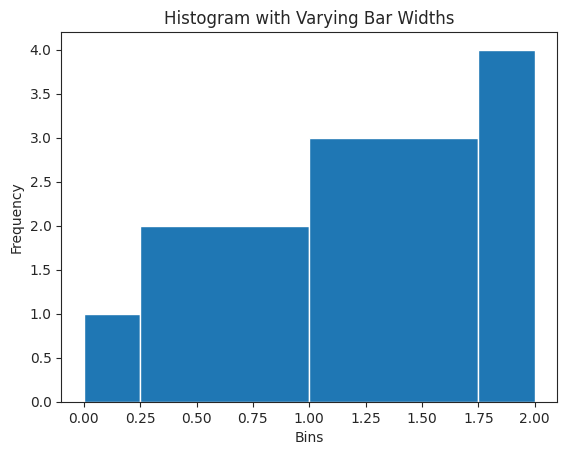

In [65]:
def tempfn(grades_dict):
    L=[(e,v) for (e,v) in grades_dict.items()]
    L.sort()
    limits=[]
    last=L[0][0]
    for (e,_) in L:
        limits.append((last+e)/2)
        last=e
    limits.append(L[-1][0])
    widths=[limits[i]-limits[i-1] for i in range(1,len(limits))]
    data=[v for (_,v) in L]
    print(limits)
    print(widths)
    print(data)
    plt.bar(limits[:-1], data, width=widths, align='edge')

    # Set labels and title
    plt.xlabel('Bins')
    plt.ylabel('Frequency')
    plt.title('Histogram with Varying Bar Widths')

    # Show the plot
    plt.show()
tempfn({0:1,0.5:2,1.5:3,2:4})
tempfn=None

In [121]:
X=counter_dict(combined_df['meanGrade'],dict())
print(X)
Y=counter_dict(combined_df['meanGrade'],dict(),ro=3)
print(Y)

-1 0
{0.20000000298023224: 1417, 1.600000023841858: 990, 1.0: 1792, 0.4000000059604645: 1720, 0.0: 799, 1.2000000476837158: 1584, 0.800000011920929: 1890, 1.399999976158142: 1293, 0.6000000238418579: 1864, 1.7999999523162842: 691, 2.200000047683716: 254, 2.0: 463, 2.4000000953674316: 141, 1.2999999523162842: 14, 2.066666603088379: 1, 0.8999999761581421: 13, 2.5999999046325684: 63, 0.5: 5, 2.799999952316284: 19, 1.5: 12, 1.899999976158142: 8, 1.7000000476837158: 15, 3.0: 5, 1.100000023841858: 12, 0.699999988079071: 13, 2.133333444595337: 1, 2.5: 2, 2.0999999046325684: 4, 0.8666666746139526: 1, 2.299999952316284: 4, 0.30000001192092896: 3, 1.3333333730697632: 1, 1.5333333015441895: 1}
3 0
{0.2: 1417, 1.6: 990, 1.0: 1792, 0.4: 1720, 0.0: 799, 1.2: 1584, 0.8: 1890, 1.4: 1293, 0.6: 1864, 1.8: 691, 2.2: 254, 2.0: 463, 2.4: 141, 1.3: 14, 2.067: 1, 0.9: 13, 2.6: 63, 0.5: 5, 2.8: 19, 1.5: 12, 1.9: 8, 1.7: 15, 3.0: 5, 1.1: 12, 0.7: 13, 2.133: 1, 2.5: 2, 2.1: 4, 0.867: 1, 2.3: 4, 0.3: 3, 1.333: 1

In [102]:
def tempfn(iL):
    D=dict()
    for e in iL:
        f=round(e,3)
        V=D.get(f,set())
        if len(V)>0:
            print(f,V,e)
        V.add(e)
        D[f]=V
print(tempfn(combined_df['meanGrade']))
tempfn=None

1.2 {1.2000000476837158} 1.2000000476837158
1.0 {1.0} 1.0
0.2 {0.20000000298023224} 0.20000000298023224
0.0 {0.0} 0.0
1.0 {1.0} 1.0
1.0 {1.0} 1.0
0.2 {0.20000000298023224} 0.20000000298023224
0.8 {0.800000011920929} 0.800000011920929
1.6 {1.600000023841858} 1.600000023841858
1.4 {1.399999976158142} 1.399999976158142
1.2 {1.2000000476837158} 1.2000000476837158
1.6 {1.600000023841858} 1.600000023841858
1.0 {1.0} 1.0
0.4 {0.4000000059604645} 0.4000000059604645
1.0 {1.0} 1.0
0.2 {0.20000000298023224} 0.20000000298023224
1.4 {1.399999976158142} 1.399999976158142
1.0 {1.0} 1.0
1.4 {1.399999976158142} 1.399999976158142
0.8 {0.800000011920929} 0.800000011920929
1.4 {1.399999976158142} 1.399999976158142
0.8 {0.800000011920929} 0.800000011920929
0.2 {0.20000000298023224} 0.20000000298023224
0.6 {0.6000000238418579} 0.6000000238418579
1.4 {1.399999976158142} 1.399999976158142
0.2 {0.20000000298023224} 0.20000000298023224
0.8 {0.800000011920929} 0.800000011920929
1.4 {1.399999976158142} 1.39999997